In [1]:
import numpy as np
import torch
import os
import net_Xavier as net
import utils
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid
from time import time
import pickle
import random
from pathlib import Path

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [2]:
BATCH_SIZE = 32
DS_FOLDER = "/home/ML_courses/03683533_2021/dataset"
LR = 1e-4
DEVICE_ID = 0
VAL_RANGE = 1000
TRAIN_RANGE = None
NUM_WORKERS = 16
NUM_EPOCHS = 20
SHUFFLE = True
RUN_NAME = 'Alex-MSE-leaky_r-tanh-xavier-shuffled'

# Network and optimizer

In [3]:
model = net.AutoEncoder(activation='leaky_r',last_activation='tanh')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
device = f'cuda:{DEVICE_ID}' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

/specific/a/home/cc/students/cs/ofekbransky/Workshop/autoencoder/net_Xavier.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


weights initialized
weights initialized
weights initialized
weights initialized
weights initialized
weights initialized
weights initialized
weights initialized
weights initialized
weights initialized
weights initialized
weights initialized
weights initialized
cuda:0


AutoEncoder(
  (activation): LeakyReLU(negative_slope=0.01)
  (last_activation): Tanh()
  (enc1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(4, 4))
  (enc1_bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (enc2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
  (enc3_bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1))
  (enc4_bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc5_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

# Data Loader & Dataset

In [4]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.ToTensor(),
                                ])

class UniDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        x = Image.open(image_path)
        if self.transform is not None:
            x = self.transform(x)
        return x
    
    def __len__(self):
        return len(self.image_paths)

In [5]:
val_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[:VAL_RANGE]]
if TRAIN_RANGE != None:
    train_files = [os.path.join(DS_FOLDER,i) for i in 
                   sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:TRAIN_RANGE+1+VAL_RANGE]]
else:
    train_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:]]

In [6]:
val_ds = UniDataset(val_files, transform=transform)
train_ds = UniDataset(train_files, transform=transform)

In [7]:
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True, shuffle=SHUFFLE)

# Train model

In [8]:
def save_imgs(true_imgs, val_imgs, dirname, epoch):
    path = os.path.join('results', RUN_NAME, epoch)
    os.makedirs(path, exist_ok=True)
    save_image(val_imgs, os.path.join(path, 'val_pred.png'))
    save_image(true_imgs, os.path.join(path, 'val_true.png'))

In [9]:
def calc_val_loss(val_dl, epoch, dirname):
    with torch.no_grad():
        val_loss = 0.0
        for images in val_dl:
            images = images.float().to(device)
            outputs = model(images)
            images.require_grad = False
            loss = criterion(outputs, images)
            val_loss += loss.item()
    images = images.cpu()
    outputs = outputs.view(outputs.size(0), 3, 256, 256).cpu().data
    save_imgs(images, outputs, dirname, epoch)
    return val_loss/len(val_dl), make_grid(images), make_grid(outputs)

In [10]:
%%time

train_losses = {}
val_losses = {}
for epoch in range(1, NUM_EPOCHS+1):
    t = time()
    train_loss = 0.0
    for images in tqdm(train_dl):
        images = images.float()
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    val_loss, val_true_grid, val_pred_grid = calc_val_loss(val_dl, str(epoch), RUN_NAME)
    train_loss = train_loss/len(train_dl)
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    print('Epoch: {} \tTraining Loss: {:.6f} \tVal Loss: {:.6f}\t \
    in time {:2f}m'.format(epoch, train_loss, val_loss, (time()-t)/60))


100%|███████████████████████████████████████| 1219/1219 [02:17<00:00,  8.87it/s]


Epoch: 1 	Training Loss: 0.040342 	Val Loss: 0.015742	     in time 2.331179m


100%|███████████████████████████████████████| 1219/1219 [02:30<00:00,  8.08it/s]


Epoch: 2 	Training Loss: 0.011250 	Val Loss: 0.008580	     in time 2.554076m


100%|███████████████████████████████████████| 1219/1219 [02:34<00:00,  7.87it/s]


Epoch: 3 	Training Loss: 0.007549 	Val Loss: 0.006879	     in time 2.622596m


100%|███████████████████████████████████████| 1219/1219 [02:35<00:00,  7.84it/s]


Epoch: 4 	Training Loss: 0.006241 	Val Loss: 0.005732	     in time 2.632508m


100%|███████████████████████████████████████| 1219/1219 [02:35<00:00,  7.84it/s]


Epoch: 5 	Training Loss: 0.005513 	Val Loss: 0.005363	     in time 2.633096m


100%|███████████████████████████████████████| 1219/1219 [02:36<00:00,  7.80it/s]


Epoch: 6 	Training Loss: 0.005141 	Val Loss: 0.005035	     in time 2.649551m


100%|███████████████████████████████████████| 1219/1219 [02:39<00:00,  7.66it/s]


Epoch: 7 	Training Loss: 0.004873 	Val Loss: 0.004918	     in time 2.693247m


100%|███████████████████████████████████████| 1219/1219 [02:37<00:00,  7.75it/s]


Epoch: 8 	Training Loss: 0.004659 	Val Loss: 0.004518	     in time 2.665125m


100%|███████████████████████████████████████| 1219/1219 [02:37<00:00,  7.74it/s]


Epoch: 9 	Training Loss: 0.004535 	Val Loss: 0.004420	     in time 2.665571m


100%|███████████████████████████████████████| 1219/1219 [02:36<00:00,  7.81it/s]


Epoch: 10 	Training Loss: 0.004389 	Val Loss: 0.004298	     in time 2.645098m


100%|███████████████████████████████████████| 1219/1219 [02:39<00:00,  7.62it/s]


Epoch: 11 	Training Loss: 0.004225 	Val Loss: 0.004440	     in time 2.707313m


100%|███████████████████████████████████████| 1219/1219 [02:31<00:00,  8.07it/s]


Epoch: 12 	Training Loss: 0.004169 	Val Loss: 0.004184	     in time 2.558272m


100%|███████████████████████████████████████| 1219/1219 [02:17<00:00,  8.85it/s]


Epoch: 13 	Training Loss: 0.004031 	Val Loss: 0.003998	     in time 2.334448m


100%|███████████████████████████████████████| 1219/1219 [02:13<00:00,  9.11it/s]


Epoch: 14 	Training Loss: 0.003935 	Val Loss: 0.003827	     in time 2.269080m


100%|███████████████████████████████████████| 1219/1219 [02:12<00:00,  9.17it/s]


Epoch: 15 	Training Loss: 0.003882 	Val Loss: 0.004032	     in time 2.255786m


100%|███████████████████████████████████████| 1219/1219 [02:12<00:00,  9.18it/s]


Epoch: 16 	Training Loss: 0.003824 	Val Loss: 0.003740	     in time 2.252450m


100%|███████████████████████████████████████| 1219/1219 [02:08<00:00,  9.51it/s]


Epoch: 17 	Training Loss: 0.003751 	Val Loss: 0.003631	     in time 2.175077m


100%|███████████████████████████████████████| 1219/1219 [02:08<00:00,  9.51it/s]


Epoch: 18 	Training Loss: 0.003673 	Val Loss: 0.003611	     in time 2.174717m


100%|███████████████████████████████████████| 1219/1219 [02:08<00:00,  9.51it/s]


Epoch: 19 	Training Loss: 0.003617 	Val Loss: 0.003537	     in time 2.173067m


100%|███████████████████████████████████████| 1219/1219 [02:08<00:00,  9.51it/s]


Epoch: 20 	Training Loss: 0.003548 	Val Loss: 0.003775	     in time 2.173166m
CPU times: user 39min 55s, sys: 12min 4s, total: 51min 59s
Wall time: 49min 9s


# Results

In [11]:
def show(img, ax = None):
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
path = Path("results") / RUN_NAME

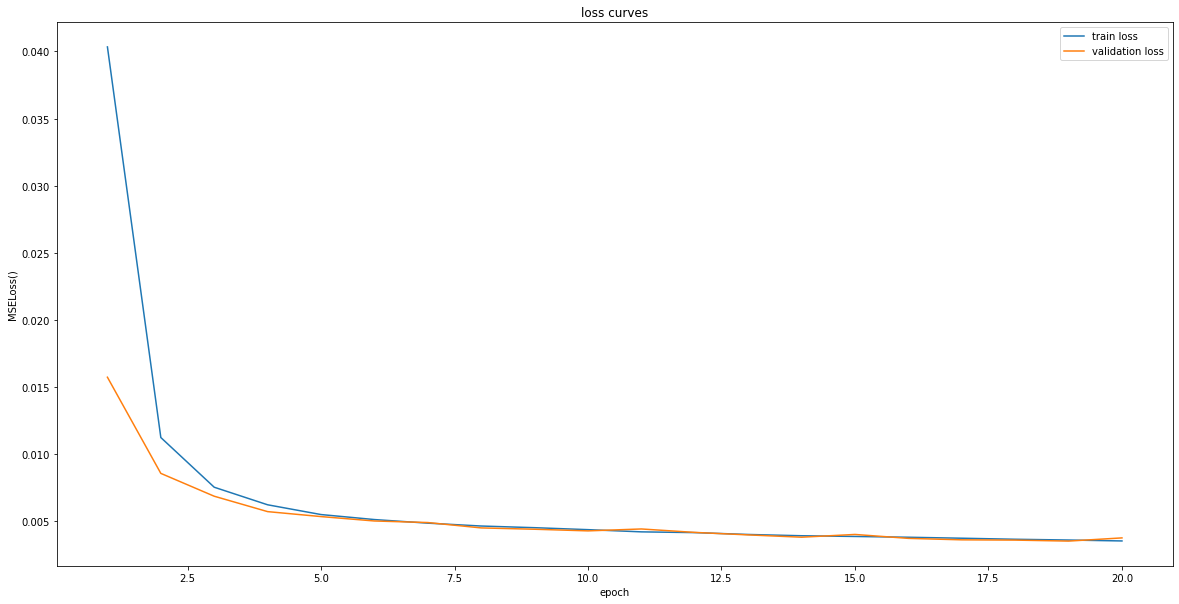

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(train_losses.keys(), train_losses.values(), label="train loss")
plt.plot(val_losses.keys(), val_losses.values(), label="validation loss")
plt.title("loss curves")
plt.legend()
plt.xlabel("epoch")
plt.ylabel(str(criterion))
plt.savefig(path / "loss_curves.png")

In [13]:
with open(path / "loss_values.txt", "w") as f:
    for i in train_losses.keys():
        f.write(f"epoch {i}: train loss is {train_losses[i]:.6f}, validation loss is {val_losses[i]:.6f}\n")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


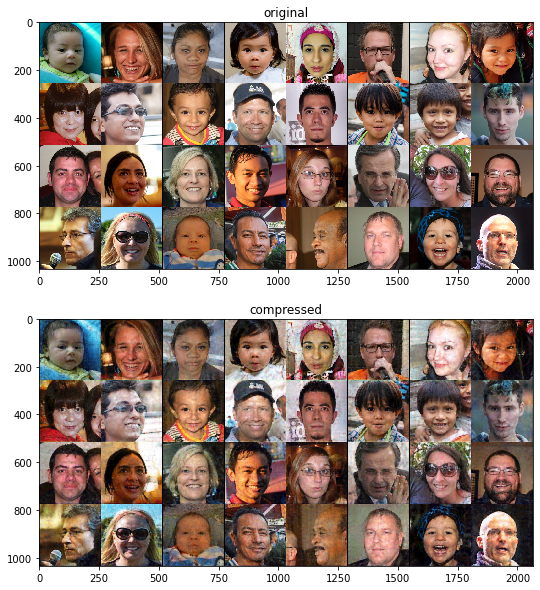

In [14]:
images = list(val_dl)[0]
outputs = model(images.to(device)).cpu()

fig, axes = plt.subplots(2, figsize=(20, 10))
show(make_grid(images), axes[0])
axes[0].set_title("original")
show(make_grid(outputs), axes[1])
axes[1].set_title("compressed")
plt.savefig( path / 'validation_compare.png')